In [1]:
import pyvips
import cv2
from skimage.transform import resize, rescale
from PIL import Image
import imutils


import numpy as np
import pandas as pd


import scanpy as sc
import anndata

import os
import warnings
from glob import glob

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['pdf.fonttype'] = 42

sc._settings.settings._vector_friendly=True

In [ ]:
sid = 38828

In [ ]:
fsid = '/common/yangy4/tunji_spmeta/heslides/{}.svs'.format(sid)

In [27]:
adata_pos = sc.read('/common/yangy4/tunji_spmeta/adata_merged_db_pos_norm_log_combat.h5ad')

In [864]:
adata_neg = sc.read('/common/yangy4/tunji_spmeta/adata_merged_db_neg_norm_log_combat.h5ad')

In [3014]:
sids = glob('/common/yangy4/tunji_spmeta/heslides/*.svs')

In [519]:
adata_pos = sc.read('/common/yangy4/tunji_spmeta/adata_merged_db_pos_norm_log_combat.h5ad')

In [1076]:
def adata2img(adata, batch, charge, scaled=True, resized=False, saveit=True, verbose=True):
    adata_sub = adata[adata.obs.batch == batch]
    xmax = adata_sub.obs.x_pixel.max()+1
    ymax = adata_sub.obs.y_pixel.max()+1
    img = np.zeros((ymax,xmax)) 
    img[adata_sub.obs.y_pixel, adata_sub.obs.x_pixel] = adata_sub.layers['counts'].sum(axis=1)#adata_sub.obs[colnm].astype('int') 

    if scaled:
        img = (img - img.min()) / (img.max() - img.min())
        if verbose:
            print('intensity was scaled')

    if resized:
        if verbose:
            print('before resizing: ', img.shape)
        r = img.shape[0] / img.shape[1]
        if r > 1:
            img = imutils.resize(img, width=200)
        else:
            img = imutils.resize(img, height=200)

        if verbose:
            print('after resizing: ', img.shape)

    if saveit:
        savenm = 'spmeta_hne_img/spmeta_{}_{}.png'.format(charge, batch)
        # cv2.imwrite(savenm, img)
        mpl.image.imsave(savenm,img)
        if verbose:
            print('img was saved as {}'.format(savenm))
    
    if verbose:
        plt.imshow(img)


    return img


In [839]:
def svs2img(fn_sid):
    image = pyvips.Image.new_from_file(fn_sid)
    img = image.numpy()
    return img

In [1083]:
def findbatchid(sid, charge, meta_sid, metadb):
    meta_tmp = meta_sid.query('slideid == @sid & ions == @charge')
    meta_tmp = meta_tmp.dropna(axis=1)

    df = []
    for position in meta_tmp.drop(['slideid','ions'], axis=1).columns:
        metadb_tmp = metadb[metadb.slide_id == meta_tmp[position].values[0]]
        batch = 'pid{}_{}'.format(metadb_tmp.pid.values[0], metadb_tmp.time.values[0])
        df.append([position, batch])
    df = pd.DataFrame(df)
    df.columns = ['position','batchid']
    df.index = df.batchid
    df = df.drop(['batchid'],axis=1)
    return df

In [1271]:
def cutnscale(img, xmin, xmax, ymin, ymax, charge, 
              erdl=True, k=70,
              resized=True, l_img=200,
              saveit=True, verbose=True):
    img = img[xmin:xmax, ymin:ymax, :3]
    img = cv2.rotate(img, cv2.ROTATE_180)

    if verbose:
        plt.imshow(img)

    if erdl:
        if verbose:
            print('To fill the gaps in tissue, perform erode/dilate')
        # Creating kernel 
        kernel = np.ones((k, k), np.uint8) 
          
        # Using cv2.erode() method  
        img = cv2.erode(img, kernel)  
        img = cv2.dilate(img, kernel)  

        if verbose:
            plt.imshow(img)

    if resized:
        if verbose:
            print('before resizing: ', img.shape)
        r = img.shape[0] / img.shape[1]
        if r > 1:
            img = imutils.resize(img, height=l_img)
        else:
            img = imutils.resize(img, width=l_img)

        if verbose:
            print('after resizing: ', img.shape)

    if saveit:
        savenm = 'spmeta_hne_img/hne_{}_{}.png'.format(charge, batch)
        if erdl:
            savenm = savenm.replace('.png','_erdl.png')
        mpl.image.imsave(savenm, img)
        if verbose:
            print('img was saved as {}'.format(savenm))
    
    if verbose:
        plt.imshow(img)


In [2873]:
def alignimgs(batch, charge, verbose=True):
    if os.path.isfile('spmeta_hne_img/spmeta_{}_{}.png'.format(charge, batch)):
        fixed = sitk.ReadImage('spmeta_hne_img/spmeta_{}_{}.png'.format(charge, batch), sitk.sitkFloat32)
        moving = sitk.ReadImage('spmeta_hne_img/hne_{}_{}_erdl.png'.format(charge, batch), sitk.sitkFloat32)
    
        moving2 = sitk.ReadImage('spmeta_hne_img/hne_{}_{}.png'.format(charge, batch), sitk.sitkFloat32)
    
        R = sitk.ImageRegistrationMethod()
        R.SetMetricAsCorrelation()
        R.SetOptimizerAsRegularStepGradientDescent(learningRate=2.0,
                                                   minStep=1e-4,
                                                   numberOfIterations=500,
                                                   gradientMagnitudeTolerance=1e-8 )
        R.SetOptimizerScalesFromIndexShift()  
        tx = sitk.CenteredTransformInitializer(fixed, moving, sitk.Similarity2DTransform())
        R.SetInitialTransform(tx) 
        R.SetInterpolator(sitk.sitkLinear)
        R.AddCommand( sitk.sitkIterationEvent, lambda: command_iteration(R) )
    
        outTx = R.Execute(fixed, moving)
        
        savenm = '../results/transform_models/tfm_{}_{}.hdf'.format(charge, batch)
        sitk.WriteTransform(outTx, savenm)
        print('saved: ', savenm)
    
        if verbose:
            print("-------")
            print(outTx)
            print("Optimizer stop condition: {0}".format(R.GetOptimizerStopConditionDescription()))
            print(" Iteration: {0}".format(R.GetOptimizerIteration()))
            print(" Metric value: {0}".format(R.GetMetricValue()))
    
        
        resampler = sitk.ResampleImageFilter()
        resampler.SetReferenceImage(fixed);
        resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetDefaultPixelValue(100)
        resampler.SetTransform(outTx)
        
        out = resampler.Execute(moving2)
        simg1 = sitk.Cast(sitk.RescaleIntensity(fixed), sitk.sitkUInt8)
        simg2 = sitk.Cast(sitk.RescaleIntensity(out), sitk.sitkUInt8)
        cimg = sitk.Compose(simg1, simg2, simg1//2.+simg2//2.)
    
        nda = sitk.GetArrayFromImage(cimg)
        
        if verbose:
            plt.imshow(nda[:,:,2])
    
        return nda

In [1124]:
batch = 'pid10_day60'

img was saved as spmeta_hne_img/spmeta_pos_pid10_day60.png


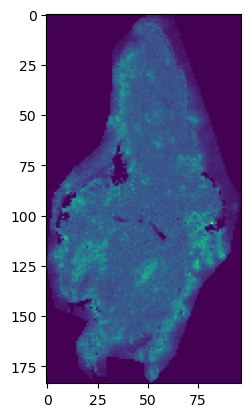

In [1077]:
template = adata2img(adata_pos, batch, 'pos', scaled=False, resized=False, saveit=True, verbose=True)

In [1079]:
l_img = np.max(template.shape)

In [1080]:
l_img

184

In [700]:
meta_sid = pd.read_csv('/common/yangy4/tunji_spmeta/metadb_slideid.csv', dtype=str)

In [704]:
metadb = pd.read_csv('/common/yangy4/tunji_spmeta/fromMETASPACE/metadb_spmeta.csv', dtype=str)

In [1937]:
k = 4

In [1938]:
sids

['/common/yangy4/tunji_spmeta/heslides/57904.svs',
 '/common/yangy4/tunji_spmeta/heslides/57903.svs',
 '/common/yangy4/tunji_spmeta/heslides/57887.svs',
 '/common/yangy4/tunji_spmeta/heslides/57892.svs',
 '/common/yangy4/tunji_spmeta/heslides/38828.svs',
 '/common/yangy4/tunji_spmeta/heslides/38825.svs']

In [1939]:
img = svs2img(sids[k])

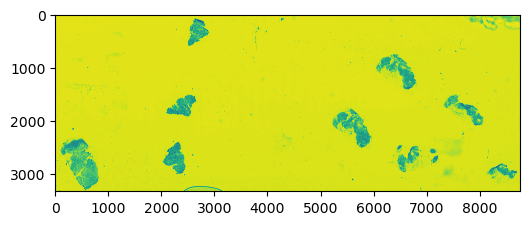

In [1940]:
plt.imshow(rescale(img, 0.1, anti_aliasing=False))

In [1941]:
sid = sids[k].split('/')[-1].split('.svs')[0]
sid

'38828'

In [1942]:
charge = meta_sid.query('slideid == @sid')['ions'].values[0]

In [1943]:
if charge == 'pos':
    adata = adata_pos.copy()
else:
    adata = adata_neg.copy()

In [1944]:
df_sample_pos = findbatchid(sid, charge, meta_sid, metadb)
df_sample_pos

,position
batchid,
pid7_day1,left
pid9_day1,middle
pid5_day60,right


In [1945]:
df_sample_pos[['xmin','xmax','ymin','ymax']] = 0

In [1946]:
batch = 'pid7_day1'

img was saved as spmeta_hne_img/spmeta_pos_pid7_day1.png


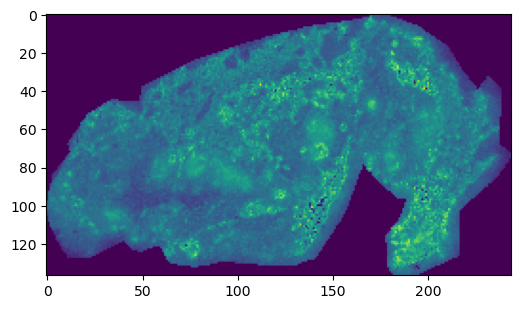

In [1947]:
template = adata2img(adata, batch, charge, scaled=False, resized=False, saveit=True, verbose=True)

In [1948]:
l_img = np.max(template.shape)
l_img

244

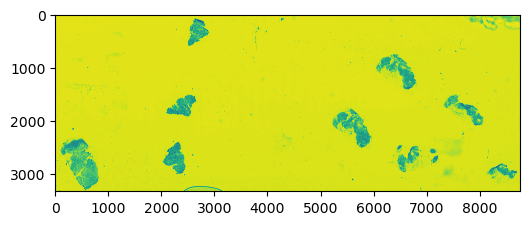

In [1940]:
plt.imshow(rescale(img, 0.1, anti_aliasing=False))

In [1949]:
img.shape

(33322, 87648, 4)

In [1952]:
xmin = 24000
xmax = 30000
ymin = 63000
ymax = 73000

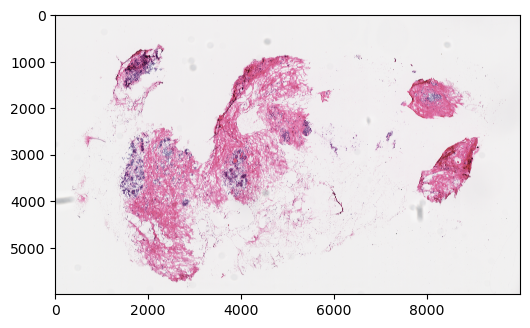

In [1953]:
plt.imshow(img[xmin:xmax, ymin:ymax, :3])

In [1954]:
df_sample_pos.loc[batch, 'xmin'] = xmin
df_sample_pos.loc[batch, 'xmax'] = xmax
df_sample_pos.loc[batch, 'ymin'] = ymin
df_sample_pos.loc[batch, 'ymax'] = ymax

To fill the gaps in tissue, perform erode/dilate
before resizing:  (6000, 10000, 3)
after resizing:  (146, 244, 3)
img was saved as spmeta_hne_img/hne_pos_pid7_day1_erdl.png


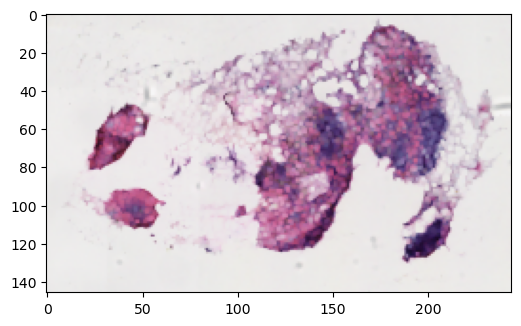

In [1955]:
cutnscale(img, xmin, xmax, ymin, ymax, charge, erdl=True, k=70, resized=True, l_img=l_img, saveit=True, verbose=True)

before resizing:  (6000, 10000, 3)
after resizing:  (146, 244, 3)
img was saved as spmeta_hne_img/hne_pos_pid7_day1.png


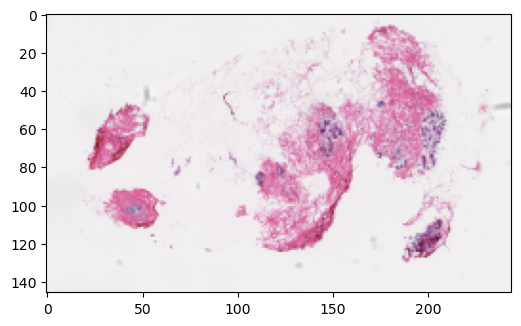

In [1956]:
cutnscale(img, xmin, xmax, ymin, ymax, charge, erdl=False, k=70, resized=True, l_img=l_img, saveit=True, verbose=True)

Estimated Scales:  (20757.569925887186, 20757.396946714365, 1.0000000000010232, 1.0000000000038654)
  0 = -0.16152 : (1.005302277017627, -0.0013461476894789928, -5.884424188440541, 2.804333217275099)
  1 = -0.19270 : (1.0086789411464803, -0.0022467238717071283, -3.884428931727031, 2.8069332606138175)
  2 = -0.21175 : (1.0079163900688521, -0.001772787696864226, -1.9004660583329944, 2.5541675372761103)
  3 = -0.22357 : (1.0009458341497632, -6.429049702713369e-06, 0.02793476650421889, 2.0238671034704567)
  4 = -0.23117 : (0.9875029637028214, 0.0017574669864510182, 1.9642590447588986, 1.5234028516537914)
  5 = -0.25023 : (0.9724802497500535, 0.002682891893932256, 3.8153584148134363, 0.7663000951947178)
  6 = -0.27005 : (0.9551240860759808, 0.002627275100306533, 5.590155134619705, -0.15554336432224414)
  7 = -0.29115 : (0.9339571877270125, 0.003760434827259216, 5.379055640034001, -2.144258447422128)
  8 = -0.28696 : (0.9345774899508504, 0.004650059911004423, 5.754883286467831, -1.2175695007

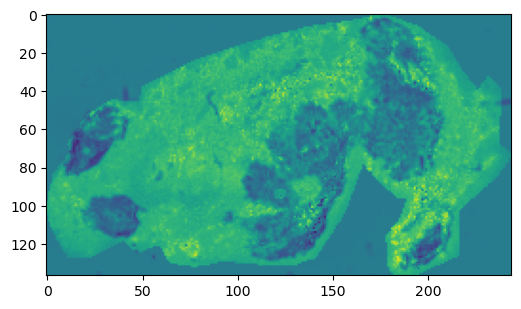

In [1957]:
a = alignimgs(batch, charge, verbose=True)

In [1958]:
df_sample_pos

,position,xmin,xmax,ymin,ymax
batchid,,,,,
pid7_day1,left,24000,30000,63000,73000
pid9_day1,middle,0,0,0,0
pid5_day60,right,0,0,0,0


In [1959]:
batch = 'pid9_day1'

img was saved as spmeta_hne_img/spmeta_pos_pid9_day1.png


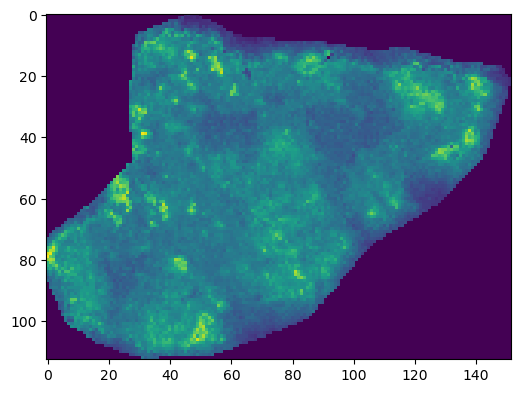

In [1960]:
template = adata2img(adata, batch, charge, scaled=False, resized=False, saveit=True, verbose=True)

In [1961]:
l_img = np.max(template.shape)
l_img

152

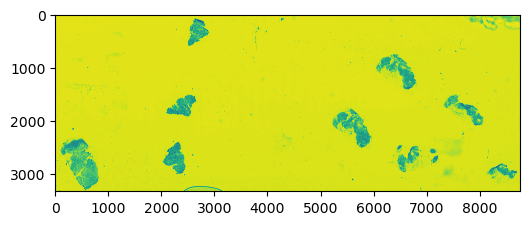

In [1940]:
plt.imshow(rescale(img, 0.1, anti_aliasing=False))

In [1964]:
xmin = 15000
xmax = 20000
ymin = 20000
ymax = 27000

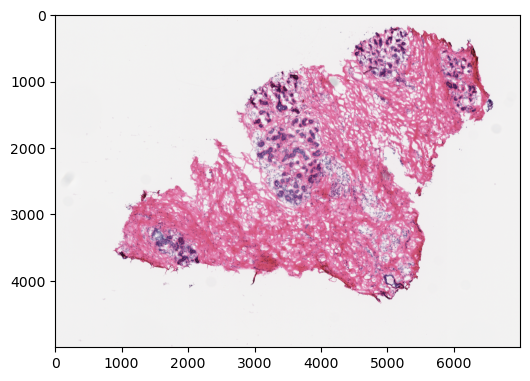

In [1965]:
plt.imshow(img[xmin:xmax, ymin:ymax, :3])

In [1966]:
df_sample_pos.loc[batch, 'xmin'] = xmin
df_sample_pos.loc[batch, 'xmax'] = xmax
df_sample_pos.loc[batch, 'ymin'] = ymin
df_sample_pos.loc[batch, 'ymax'] = ymax

To fill the gaps in tissue, perform erode/dilate
before resizing:  (5000, 7000, 3)
after resizing:  (108, 152, 3)
img was saved as spmeta_hne_img/hne_pos_pid9_day1_erdl.png


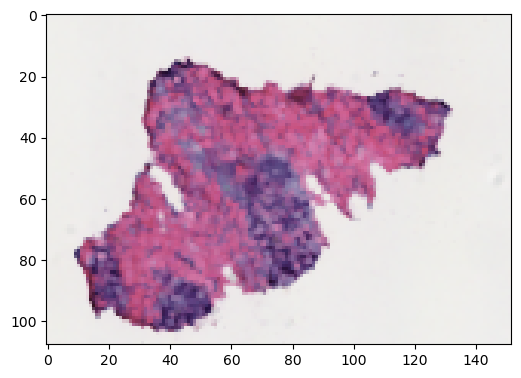

In [1967]:
cutnscale(img, xmin, xmax, ymin, ymax, charge, erdl=True, k=70, resized=True, l_img=l_img, saveit=True, verbose=True)

before resizing:  (5000, 7000, 3)
after resizing:  (108, 152, 3)
img was saved as spmeta_hne_img/hne_pos_pid9_day1.png


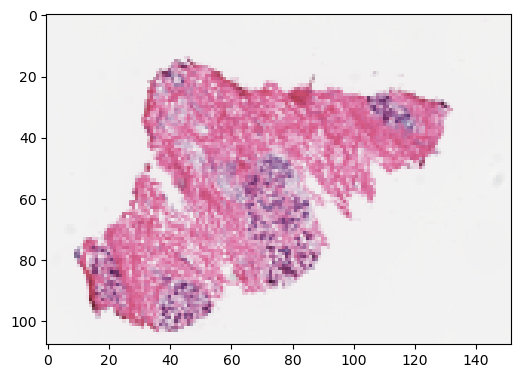

In [1968]:
cutnscale(img, xmin, xmax, ymin, ymax, charge, erdl=False, k=70, resized=True, l_img=l_img, saveit=True, verbose=True)

Estimated Scales:  (9680.837877296326, 9680.757203916372, 1.0000000000010232, 1.0000000000010232)
  0 = -0.24506 : (0.9866127560813703, -0.002097844687410081, 5.967771861942817, -2.9652321790095466)
  1 = -0.28412 : (0.9591824624293922, -0.004038940122062457, 3.970524343004171, -2.864008865330804)
  2 = -0.34014 : (0.9259457094756279, -0.0046183731524171295, 2.1498998107725322, -2.036832164046984)
  3 = -0.40537 : (0.8982364356871531, -0.0048915038495275145, 0.5823664981715735, -0.7950304747938237)
  4 = -0.47493 : (0.8683511453129754, -0.005842562713750904, -0.910567347454112, 0.5354786373476863)
  5 = -0.56314 : (0.8358842909479461, -0.006212761661766139, -2.4842832832901784, 1.7693197614864435)
  6 = -0.67018 : (0.7658432063372816, -0.0066935786025653895, -3.811330288255478, 3.2639903813536635)
  7 = -0.64075 : (0.7753363496914425, -0.009370066220738257, -4.334547439980042, 2.4118480641410267)
  8 = -0.68433 : (0.8012268832584954, -0.016546288286795996, -4.67516096625419, 1.47202860

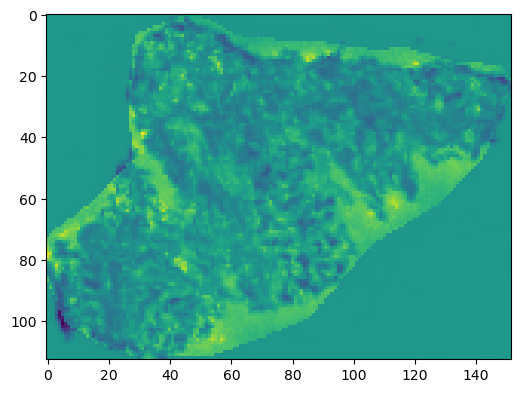

In [1969]:
a=alignimgs(batch, charge, verbose=True)

In [1970]:
df_sample_pos

,position,xmin,xmax,ymin,ymax
batchid,,,,,
pid7_day1,left,24000,30000,63000,73000
pid9_day1,middle,15000,20000,20000,27000
pid5_day60,right,0,0,0,0


In [1971]:
tmp = df_sample_pos.copy()
tmp['sid'] = sid
tmp['ions'] = charge
df_pos_all = pd.concat([df_pos_all, tmp])

In [1972]:
df_pos_all

,position,xmin,xmax,ymin,ymax,sid,ions
batchid,,,,,,,
pid7_day60,left,5000.0,10000.0,55000.0,62000.0,38826,pos
pid10_day60,right,4000.0,12000.0,13000.0,19000.0,38826,pos
pid7_day1,left,18000.0,25000.0,77000.0,87640.0,38827,neg
pid9_day1,middle,15000.0,21000.0,37000.0,43000.0,38827,neg
pid5_day60,right,18000.0,25000.0,77000.0,88000.0,38827,neg
pid9_day60,left,21000.0,26000.0,60000.0,65000.0,57902,pos
pid2_day60,right,500.0,6000.0,17000.0,21000.0,57902,pos
pid3_day60,left,9000.0,14000.0,69000.0,76000.0,57888,neg
pid4_day60,middle,500.0,6000.0,27000.0,31000.0,57888,neg


In [1973]:
k = 5

In [1974]:
sids

['/common/yangy4/tunji_spmeta/heslides/57904.svs',
 '/common/yangy4/tunji_spmeta/heslides/57903.svs',
 '/common/yangy4/tunji_spmeta/heslides/57887.svs',
 '/common/yangy4/tunji_spmeta/heslides/57892.svs',
 '/common/yangy4/tunji_spmeta/heslides/38828.svs',
 '/common/yangy4/tunji_spmeta/heslides/38825.svs']

In [1975]:
img = svs2img(sids[k])

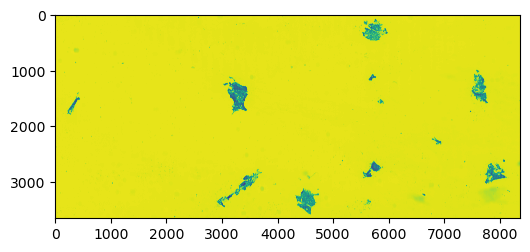

In [1976]:
plt.imshow(rescale(img, 0.1, anti_aliasing=False))

In [1977]:
sid = sids[k].split('/')[-1].split('.svs')[0]
sid

'38825'

In [1978]:
charge = meta_sid.query('slideid == @sid')['ions'].values[0]

In [1979]:
if charge == 'pos':
    adata = adata_pos.copy()
else:
    adata = adata_neg.copy()

In [1980]:
df_sample_pos = findbatchid(sid, charge, meta_sid, metadb)
df_sample_pos

,position
batchid,
pid7_day60,left
pid10_day60,right


In [1981]:
df_sample_pos[['xmin','xmax','ymin','ymax']] = 0

In [1982]:
batch = 'pid7_day60'

img was saved as spmeta_hne_img/spmeta_neg_pid7_day60.png


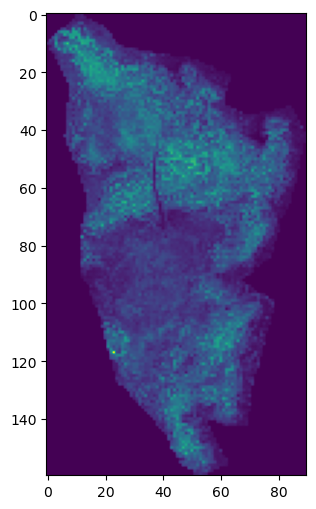

In [1983]:
template = adata2img(adata, batch, charge, scaled=False, resized=False, saveit=True, verbose=True)

In [1984]:
l_img = np.max(template.shape)
l_img

160

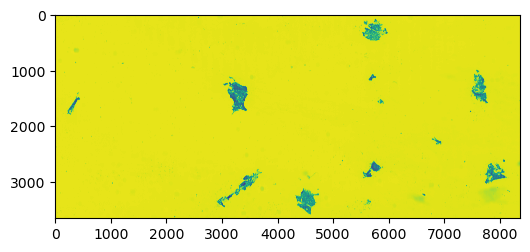

In [1976]:
plt.imshow(rescale(img, 0.1, anti_aliasing=False))

In [1985]:
img.shape

(36540, 83664, 4)

In [1990]:
xmin = 9000
xmax = 17000
ymin = 74000
ymax = 78000

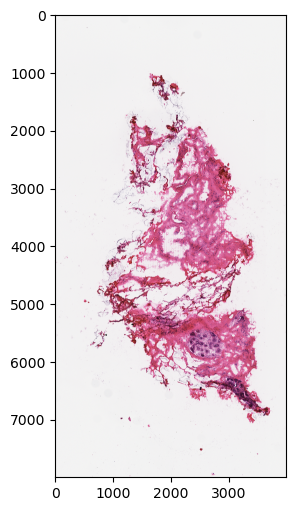

In [1991]:
plt.imshow(img[xmin:xmax, ymin:ymax, :3])

In [1992]:
df_sample_pos.loc[batch, 'xmin'] = xmin
df_sample_pos.loc[batch, 'xmax'] = xmax
df_sample_pos.loc[batch, 'ymin'] = ymin
df_sample_pos.loc[batch, 'ymax'] = ymax

To fill the gaps in tissue, perform erode/dilate
before resizing:  (8000, 4000, 3)
after resizing:  (160, 80, 3)
img was saved as spmeta_hne_img/hne_neg_pid7_day60_erdl.png


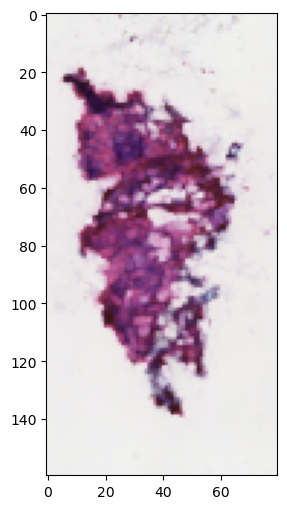

In [1993]:
cutnscale(img, xmin, xmax, ymin, ymax, charge, erdl=True, k=70, resized=True, l_img=l_img, saveit=True, verbose=True)

before resizing:  (8000, 4000, 3)
after resizing:  (160, 80, 3)
img was saved as spmeta_hne_img/hne_neg_pid7_day60.png


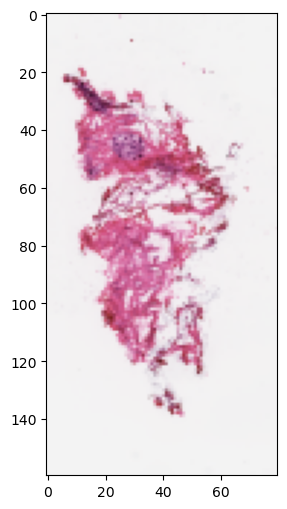

In [1994]:
cutnscale(img, xmin, xmax, ymin, ymax, charge, erdl=False, k=70, resized=True, l_img=l_img, saveit=True, verbose=True)

Estimated Scales:  (9144.539407567267, 9144.463203326237, 0.9999999999996021, 1.0000000000038654)
  0 = -0.25722 : (0.9745271197719104, 0.00030934165314923585, -4.97718228496416, 7.544417105234356)
  1 = -0.28662 : (0.9045494051983464, 0.022383796578343735, -6.782067127156591, 6.685926252442771)
  2 = -0.36814 : (0.8937678639346089, 0.027035627625496127, -6.318041249563158, 5.800182438600681)
  3 = -0.38478 : (0.8731331184055093, 0.029954884207861434, -6.342936985682975, 4.800709633797564)
  4 = -0.40560 : (0.8545100563433232, 0.027990853084800916, -6.496103174413376, 3.8126866367114745)
  5 = -0.42867 : (0.8430352787706432, 0.025111689408752497, -6.506361841259307, 2.8128092444024335)
  6 = -0.45681 : (0.8313237712731488, 0.021531922632201442, -6.604809423290097, 1.8177423625024014)
  7 = -0.49128 : (0.8183745025358732, 0.017577419634506916, -6.734760800911351, 0.8263144438923044)
  8 = -0.53696 : (0.8039062139242704, 0.01326293840708486, -6.778527265924051, -0.17261325640270786)
  9 

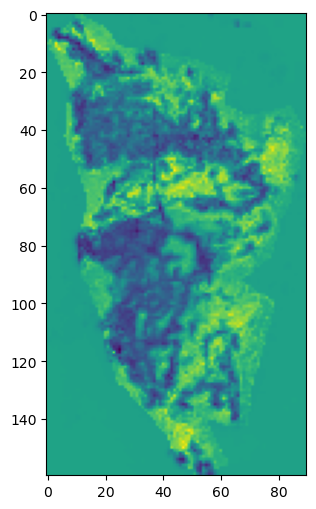

In [1995]:
a = alignimgs(batch, charge, verbose=True)

In [1996]:
df_sample_pos

,position,xmin,xmax,ymin,ymax
batchid,,,,,
pid7_day60,left,9000,17000,74000,78000
pid10_day60,right,0,0,0,0


In [1997]:
batch = 'pid10_day60'

img was saved as spmeta_hne_img/spmeta_neg_pid10_day60.png


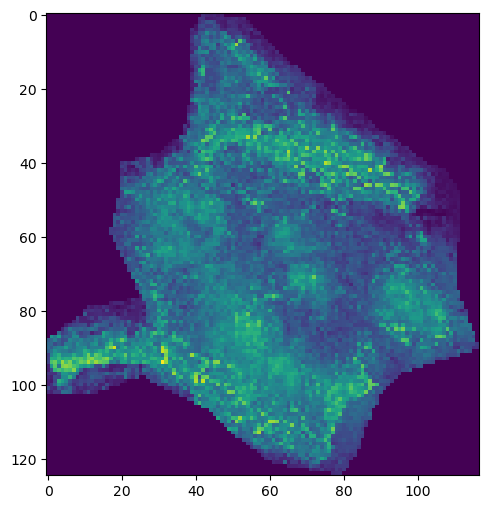

In [1998]:
template = adata2img(adata, batch, charge, scaled=False, resized=False, saveit=True, verbose=True)

In [1999]:
l_img = np.max(template.shape)
l_img

125

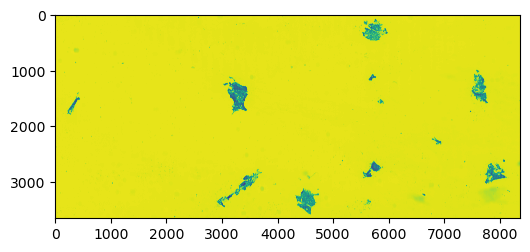

In [1976]:
plt.imshow(rescale(img, 0.1, anti_aliasing=False))

In [2004]:
xmin = 31000
xmax = 36500
ymin = 42500
ymax = 47500

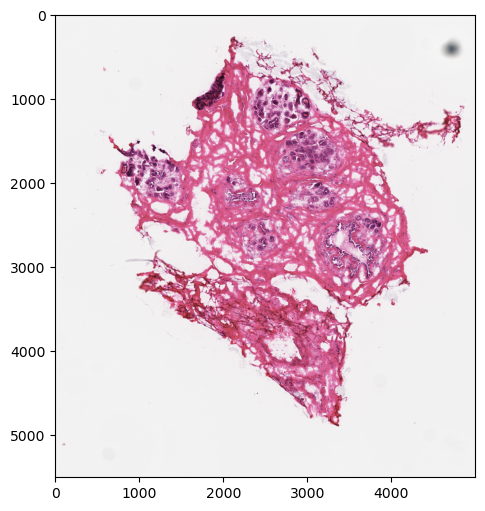

In [2005]:
plt.imshow(img[xmin:xmax, ymin:ymax, :3])

In [2006]:
df_sample_pos.loc[batch, 'xmin'] = xmin
df_sample_pos.loc[batch, 'xmax'] = xmax
df_sample_pos.loc[batch, 'ymin'] = ymin
df_sample_pos.loc[batch, 'ymax'] = ymax

To fill the gaps in tissue, perform erode/dilate
before resizing:  (5500, 5000, 3)
after resizing:  (125, 113, 3)
img was saved as spmeta_hne_img/hne_neg_pid10_day60_erdl.png


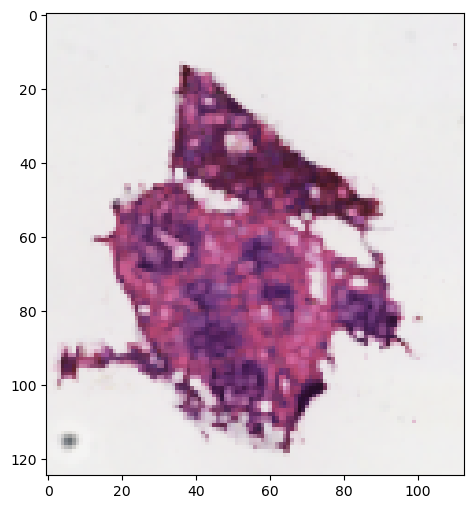

In [2007]:
cutnscale(img, xmin, xmax, ymin, ymax, charge, erdl=True, k=70, resized=True, l_img=l_img, saveit=True, verbose=True)

before resizing:  (5500, 5000, 3)
after resizing:  (125, 113, 3)
img was saved as spmeta_hne_img/hne_neg_pid10_day60.png


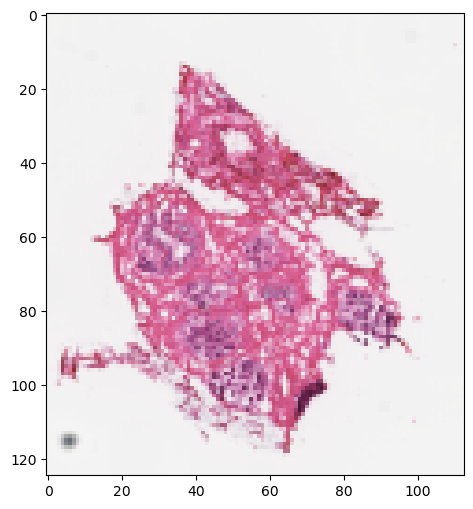

In [2008]:
cutnscale(img, xmin, xmax, ymin, ymax, charge, erdl=False, k=70, resized=True, l_img=l_img, saveit=True, verbose=True)

Estimated Scales:  (7924.63831645077, 7924.572278018222, 0.9999999999996021, 1.0000000000010232)
  0 = -0.28280 : (0.9996412378197725, -0.0023154245768036695, -3.6333907480864074, -4.778573305435516)
  1 = -0.33959 : (0.9975163625011644, -0.00382806143686372, -4.858710468462148, -3.1978820706610174)
  2 = -0.39139 : (0.9913547426483835, -0.004659898800012269, -5.9521313438982695, -1.5232501315030738)
  3 = -0.43939 : (0.9764101425483999, -0.004739055483478979, -6.957231433697747, 0.20578152296342345)
  4 = -0.49060 : (0.948775068384694, -0.004499151954019235, -7.8549881175852665, 1.9927535937181815)
  5 = -0.55779 : (0.9023290375385788, -0.005301522692267298, -8.80378582376459, 3.752760705967644)
  6 = -0.64632 : (0.8913958206842583, -0.00550452769617096, -8.090133794966293, 3.052345682320764)
  7 = -0.67068 : (0.84704400768504, -0.01035965447171184, -7.1210775926200185, 3.295120106677801)
  8 = -0.69938 : (0.8482722760078999, -0.011526618224522648, -7.620772709410355, 3.27774426688748

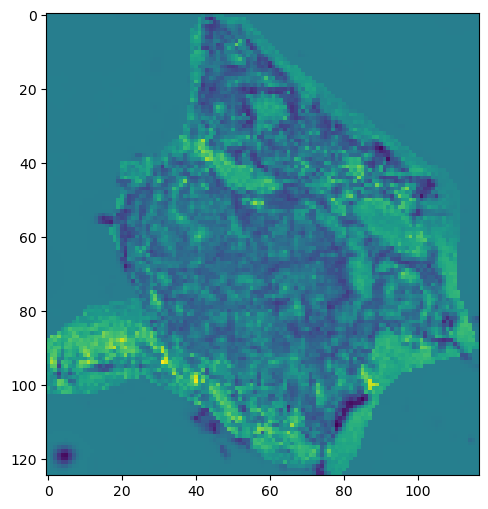

In [2009]:
a=alignimgs(batch, charge, verbose=True)